In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
col_types = {'net_assets':np.float64, 'fund_yield':np.float64,
       'net_annual_expense_ratio_fund':np.float64,'portfolio_stocks':np.float64,
       'price_earnings':np.float64, 'price_book':np.float64, 'price_sales':np.float64, 'price_cashflow':np.float64,
       'basic_materials':np.float64, 'consumer_cyclical':np.float64, 'financial_services':np.float64,
       'real_estate':np.float64, 'consumer_defensive':np.float64, 'healthcare':np.float64, 'utilities':np.float64,
       'communication_services':np.float64, 'energy':np.float64, 'industrials':np.float64, 'technology':np.float64, 
       'fund_beta_3years':np.float64, 'fund_beta_5years':np.float64, 'fund_beta_10years':np.float64,
       'fund_standard_deviation_3years':np.float64, 'fund_standard_deviation_5years':np.float64,
       'fund_standard_deviation_10years':np.float64, 'fund_return_10years':np.float64}

In [27]:
df_mf = pd.read_csv('mfdata.csv',dtype=col_types)
df_mf.shape[0]

25308

In [28]:
df_mf = df_mf[(df_mf['investment'] == 'Blend') | (df_mf['investment'] == 'Growth') | (df_mf['investment'] == 'Value')]
df_mf = df_mf[(df_mf['portfolio_stocks'] + df_mf['portfolio_cash']) > 95]
df_mf = df_mf[df_mf['portfolio_stocks'] > 80]
df_mf = df_mf[df_mf['fund_return_10years'] != 0]

In [29]:
#df_mf.columns

In [30]:
selected_columns = [
       'net_assets', 'fund_yield', 'investment', 'size',
       'net_annual_expense_ratio_fund','portfolio_stocks',
       'price_earnings', 'price_book', 'price_sales', 'price_cashflow',
       'basic_materials', 'consumer_cyclical', 'financial_services',
       'real_estate', 'consumer_defensive', 'healthcare', 'utilities',
       'communication_services', 'energy', 'industrials', 'technology', 'fund_beta_3years',
       'fund_beta_5years', 'fund_beta_10years',
       'fund_standard_deviation_3years', 'fund_standard_deviation_5years',
       'fund_standard_deviation_10years', 'fund_return_10years']

In [31]:
df_mf = df_mf[selected_columns]

In [32]:
df_mf.shape[0]

8558

In [33]:
df_mf.shape[0] - df_mf.dropna().shape[0]

44

In [34]:
df_mf.dropna(inplace=True)

In [35]:
df_mf.shape[0] - df_mf.dropna().shape[0]

0

In [36]:
s_rets = df_mf['fund_return_10years']
df_mf = df_mf.drop('fund_return_10years',axis=1)

In [37]:
s_rets = s_rets > 13.6
s_rets = s_rets.astype(int)
sum(s_rets)/len(s_rets)

0.5494479680526192

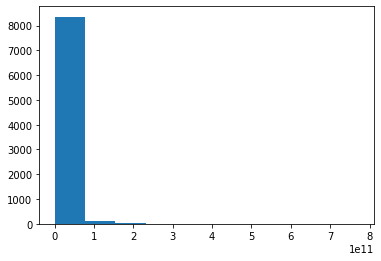

In [38]:
plt.hist(df_mf['net_assets'])
plt.show()

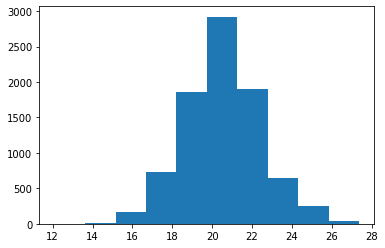

In [40]:
df_mf['net_assets'] = df_mf['net_assets'].apply(lambda x: math.log(x))

plt.hist(df_mf['net_assets'])
plt.show()

In [42]:
investment_dummies = pd.get_dummies(df_mf['investment'],prefix="investment")
size_dummies = pd.get_dummies(df_mf['size'],prefix="size")

df_mf = pd.concat([df_mf,investment_dummies,size_dummies], axis=1)
df_mf = df_mf.drop(['investment','size'],axis=1)

df_mf.head()

,net_assets,fund_yield,net_annual_expense_ratio_fund,portfolio_stocks,price_earnings,price_book,price_sales,price_cashflow,basic_materials,consumer_cyclical,...,fund_beta_10years,fund_standard_deviation_3years,fund_standard_deviation_5years,fund_standard_deviation_10years,investment_Blend,investment_Growth,investment_Value,size_Large,size_Medium,size_Small
2,20.800227,0.0,1.15,97.06,24.49,5.78,4.45,14.29,0.00,20.20,...,1.11,13.36,13.40,14.89,0,1,0,1,0,0
24,18.265780,1.0,1.79,99.99,12.29,1.61,0.85,10.20,7.56,29.10,...,1.01,13.76,17.00,20.17,1,0,0,1,0,0
26,20.163775,1.0,0.86,95.43,12.69,1.53,0.92,5.03,4.37,15.77,...,1.21,14.53,14.40,16.23,0,0,1,0,1,0
30,16.064695,0.0,1.95,89.52,26.07,3.46,2.06,16.87,5.56,12.50,...,1.06,12.94,12.14,17.56,0,1,0,0,1,0
35,22.481124,2.0,0.62,94.77,12.54,1.76,1.23,3.69,3.67,10.58,...,1.09,12.88,13.06,14.31,0,0,1,1,0,0


In [75]:
k_values = [x for x in range(3,11)]
accuracy_test = []
accuracy_train = []

X_train, X_test, y_train, y_test = train_test_split(df_mf, s_rets, test_size=0.25, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [76]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.to_numpy())
X_test_scaled = scaler.transform(X_test.to_numpy())

pca = PCA(.99)

pca.fit(X_train_scaled)

X_train_scaled = pca.transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

pca.n_components_

18

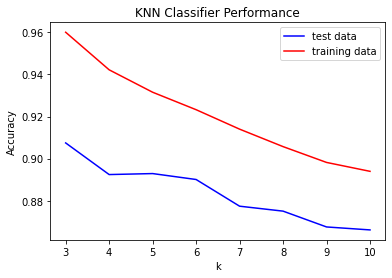

In [77]:
for val in k_values:
    
    knn = KNeighborsClassifier(n_neighbors = val,n_jobs=-1)
    knn.fit(X_train_scaled, y_train.to_numpy())
    
    acc_test = knn.score(X_test_scaled,y_test.to_numpy())
    accuracy_test.append(acc_test)
    
    acc_train = knn.score(X_train_scaled,y_train.to_numpy())
    accuracy_train.append(acc_train)
    
plt.plot(k_values,accuracy_test,color='blue',label='test data')
plt.plot(k_values,accuracy_train,color='red',label='training data')
plt.legend(loc="upper right")
plt.title('KNN Classifier Performance')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

In [78]:
df_etfs = pd.read_csv('ETFs.csv',dtype=col_types)
df_etfs.shape[0]

2352

In [79]:
df_etfs = df_etfs[(df_etfs['investment'] == 'Blend') | (df_etfs['investment'] == 'Growth') | (df_etfs['investment'] == 'Value')]
df_etfs = df_etfs[df_etfs['portfolio_stocks'] > 90]
df_etfs = df_etfs[df_etfs['fund_return_10years'] != 0]

In [80]:
df_etfs = df_etfs[selected_columns]

In [81]:
df_etfs.shape[0]

505

In [82]:
df_etfs.shape[0] - df_etfs.dropna().shape[0]

5

In [83]:
df_etfs.dropna(inplace=True)

In [84]:
s_rets_etf = df_etfs['fund_return_10years']
df_etfs = df_etfs.drop('fund_return_10years',axis=1)

In [85]:
s_rets_etf = s_rets_etf > 13.6
s_rets_etf = s_rets_etf.astype(int)
sum(s_rets_etf)/len(s_rets_etf)

0.446

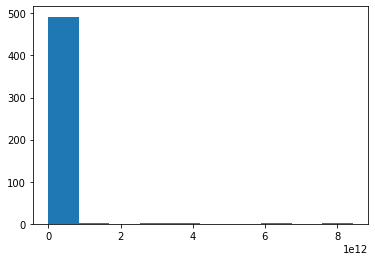

In [86]:
plt.hist(df_etfs['net_assets'])
plt.show()

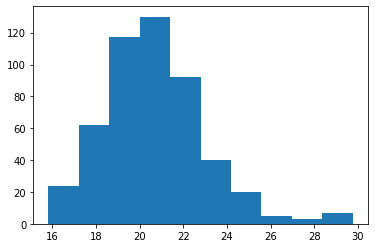

In [87]:
df_etfs['net_assets'] = df_etfs['net_assets'].apply(lambda x: math.log(x))

plt.hist(df_etfs['net_assets'])
plt.show()

In [88]:
investment_dummies = pd.get_dummies(df_etfs['investment'],prefix="investment")
size_dummies = pd.get_dummies(df_etfs['size'],prefix="size")

df_etfs = pd.concat([df_etfs,investment_dummies,size_dummies], axis=1)
df_etfs = df_etfs.drop(['investment','size'],axis=1)
df_etfs.reset_index(inplace=True,drop=True)

df_etfs.head()

,net_assets,fund_yield,net_annual_expense_ratio_fund,portfolio_stocks,price_earnings,price_book,price_sales,price_cashflow,basic_materials,consumer_cyclical,...,fund_beta_10years,fund_standard_deviation_3years,fund_standard_deviation_5years,fund_standard_deviation_10years,investment_Blend,investment_Growth,investment_Value,size_Large,size_Medium,size_Small
0,29.019812,1.84,0.00,100.00,12.92,1.18,0.81,5.41,7.81,17.26,...,0.99,14.38,14.75,16.89,1,0,0,1,0,0
1,29.762818,1.77,0.05,99.99,12.92,1.18,0.81,5.41,7.81,17.26,...,0.98,14.38,14.75,16.83,1,0,0,1,0,0
2,28.947429,1.84,0.00,99.08,12.92,1.18,0.81,5.44,7.74,17.33,...,0.99,14.38,14.75,16.90,1,0,0,1,0,0
3,21.375591,2.57,0.00,100.00,11.34,1.12,1.07,4.06,2.41,14.25,...,1.06,15.16,16.21,18.39,1,0,0,1,0,0
4,21.904993,1.82,0.00,99.90,11.34,1.12,1.07,4.07,2.44,14.26,...,1.06,15.16,16.22,18.38,1,0,0,1,0,0


In [89]:
X_etfs_scaled = scaler.transform(df_etfs.to_numpy())
X_etfs_scaled = pca.transform(X_etfs_scaled)

In [90]:
knn = KNeighborsClassifier(n_neighbors = 3,n_jobs=-1)
knn.fit(X_train_scaled, y_train.to_numpy())

etf_acc = knn.score(X_etfs_scaled,s_rets_etf.to_numpy())

In [91]:
etf_acc

0.798